## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import maxflow
import imageio

from scipy.ndimage import convolve, affine_transform
from skimage.feature import peak_local_max
from scipy.signal import find_peaks
from skimage.draw import polygon2mask
from scipy.interpolate import RegularGridInterpolator 
from IPython.display import display, clear_output

import sys
sys.path.insert(1, '..')
from functions import *

PATH = 'data/'

## 6.4 Exercise: Segmentation and tracking

**1. Read in and inspect the movie data.**

In python you may use function get_reader from imageio package. In MATLAB you may use VideoReader.


**2. Process movie frames**

For our segmentation method to work, movie frames need to be transformed in grayscale images with a significant difference in intensities of the foreground and a background. For the movie showing the crawling amoeba (which is white on a dark background), it is enough to convert movie frames to grayscale images. Transforming intensities to doubles between 0 and 1 is advisable, as it might prevent issues in subsequent processing. For the movie of the echinicsus, we want to utilize the fact that foreground is yellow
while background is blue. A example of suitable transformation is $(2b − (r + g) + 2)/4$, with $r$, $g$, $b$ being color channels (with values between 0 and 1) of movie frames.

**3. Choose a starting frame and initialize a snake**

So that it roughly delineates the foreground object. You may define a circular snake with points $(x_0 + r cos \alpha, y_0 + r sin \alpha)$, where $(x_0, y_0)$ is a circle center, $r$ is a radius and angular parameter α takes n values from $[0, 2π⟩$. See Figure 6.2 for example, but use approximately 100 points along the curve.

**4. Compute mean intensities inside and outside the snake.** 

In python use ```polygon2maskfrom``` package ```skimage.drawintroduced``` in version 0.16. In MATLAB you can use ```poly2mask``` function.

**5. Compute the magnitude of the snake displacement given by Eq. (6.1)**

That is, for each snake point, compute the scalar value giving the (signed) length of the deformation in the normal direction. This depends on image data under the snake and estimated mean intensities, as shown in Figure 6.3. A simple approach evaluates the image intensities under the snake by rounding the coordinates of the snake points. A more advanced approach involves interpolating the image at the positions of snake points for example using bilinear interpolation. Image interpolation is in python available in ```scipy.interpolate``` package, for example check the class ```RegularGridInterpolator``` or one of the other interpolants. You can also use the function map_coordinates from ```scipy.ndimage```. In MATLAB you can use function ```interp2```.

$$
\bm{F}_\text{ext} =  (m_\text{in} - m_\text{out}) \cdot (2\bm{I} - m_\text{in} - m_\text{out}) \bm{N}
\tag{6.1}
$$

where $m_\text{in}$ and $m_\text{out}$ are mean intensities inside and outside the snake, respectively, $\bm{I}$ is the image intensity, and $\bm{N}$ denotes an outward unit normal of the curve. The force is orthogonal to the snake at each point.

**6. Write a function which takes snake points C as an input and returns snake normals N.**

A normal to point $c_i$ can be approximated by a unit vector orthogonal to $c_{i+1} − c_{i−1}$. (Alternatively, and slightly better, you may average the normals of two line segments meeting at $c_i$.) Displace the snake. Estimate a reasonable value for the size of the update step by visualizing the displacement. You should
later fine-tune this value so that the segmentation runs sufficiently fast, but without introducing exaggerated oscillations. This step corresponds to computing the expression in the parentheses in the Eq. (6.3).

$$
\bm{C}^t = \bm{B}_\text{int} (\bm{C}^{t-1} + \tau \text{diag}(\bm{f}_\text{ext})\bm{N}^{t-1})
\tag{6.3}
$$

**7. Write a function which given $\alpha$, $\beta$ and $n$ constructs a regularization matrix $\bm{B}_\text{int}$**

Your code from the introductory exercise could be used. Apply regularization to a snake. Estimate a reasonable values for the regularization parameters $\alpha$ and $\beta$ by visualizing the effect of regularization. You should later fine-tune these values to obtain a segmentation with the boundary which is both smooth and sufficiently detailed. This step corresponds to matrix multiplication on the right hand side of the Eq. (6.3).

**8. The quality of the curve representation may deteriorate during evolution**

Especially, if you use a large time step $\tau$ and/or weak regularization, i.e. small $\alpha$ and $\beta$. To allow faster evolution without curve deterioration, you may choose to apply a number of substeps (implemented as subfunctions) which ensure the quality of the snake:

- Constrain snake to image domain.
- Distribute points equidistantly along the snake. This can be obtained using 1D interpolation.
- Apply heuristics for removing crossings from the snake. For example, if you detect self-intersection, identify two curve segments separated by the intersection and reverse the ordering of the smallest segment.

We provide functions for distributing points and removing crossings, in python and in MATLAB. 

**Note**: the provided functions may be expecting the snake to be $2 \times n$ matrix, so make sure to check how the function is to be used.

**9. Repeat steps 4–8 until a desirable segmentation is achieved.**

**Note**: That the regularization matrix only depends on regularization parameters and a number of snake points. This is constant when the size of the snake and the regularization are fixed, which is a typical case. It is therefore sufficient to precompute $\bm{B}_\text{int}$ prior to looping. Figure 6.5 shows our 20-point snake during evolution.

**10. Read in the next frame of the movie, and use the results of the previous frame as an initialization**

Evolve the curve a few times by repeating steps 4–8.

## Code

(588, 588)


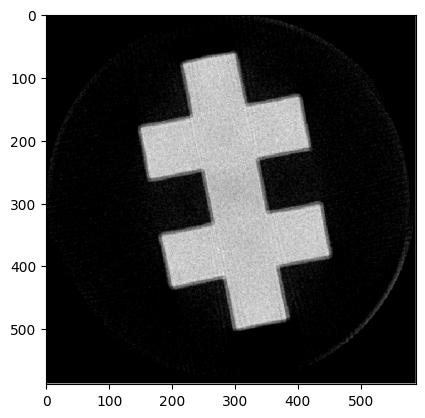

In [2]:
image = get_gray_image_float(PATH + 'plusplus.png')
print(image.shape)
plt.imshow(image, cmap='gray')

#file = 'crawling_amoeba.mov' 

## task 1

### echiniscus.mp4


(240, 320)


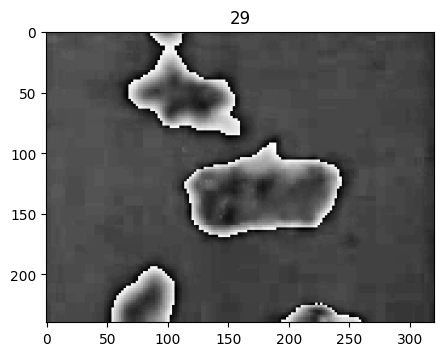

In [3]:
video_reader = imageio.get_reader(PATH + 'echiniscus.mp4')
metadata = video_reader.get_meta_data()

# Extract relevant metadata
fps = metadata.get('fps')
width, height = metadata.get('size')
print('The data aviable is\n', metadata)

frames_gray_list = []
for frame in video_reader:
    r, g, b = frame[:, :, 0], frame[:, :, 1], frame[:, :, 2]
    frame_transform = (2*b - (r + g) + 2)/4
    frames_gray_list.append(frame_transform)

start_frame = 70
end_frame = 100
frames = frames_gray_list[start_frame:end_frame]

fig, ax = plt.subplots(figsize=(5, 5))
for i, frame in enumerate(frames):
    ax.clear()
    ax.imshow(frame, cmap='gray')
    ax.set_title(i)
    display(fig)
    clear_output(wait=True) 

print(frames[1].shape)
    

In [4]:
#video_reader = imageio.get_reader(PATH + 'crawling_amoeba.mov')
#metadata = video_reader.get_meta_data()
#
## Extract relevant metadata
#fps = metadata.get('fps')
#width, height = metadata.get('size')
#print('The data aviable is\n', metadata)
#
#frames_gray_list = []
#for frame in video_reader:
#    frames_gray_list.append(skimage.img_as_float(skimage.color.rgb2gray(frame)))
#
#start_frame = 150
#end_frame = 200
#frames = frames_gray_list[start_frame:end_frame]
#
#fig, ax = plt.subplots(figsize=(5, 5))
#for i, frame in enumerate(frames):
#    ax.clear()
#    ax.imshow(frame, cmap='gray')
#    ax.set_title(i)
#    display(fig)
#    clear_output(wait=True) 

## task 3


In [5]:
def initialize_circle(center, radius, numbers):
    """
    Initialize a circular snake with given center, radius, and number of points.

    Parameters:
        center (tuple): The (x, y) coordinates of the circle center.
        radius (float): The radius of the circle.
        numbers (int): The number of points along the circle.

    Returns:
        numpy.ndarray: An array of shape (numbers, 2) containing the (x, y) coordinates of the circle points.
    """

    x0, y0 = center
    step = 2*np.pi/numbers
    angles = np.arange(0, 2*np.pi, step)[:, None]
    
    x = x0 + radius * np.cos(angles)
    y = y0 + radius * np.sin(angles)
    return np.hstack([x,y])

## task 4

In [6]:
def get_means(image, snake_points):
    circle_mask = polygon2mask(image.shape, snake_points)              # create a mask for what is inside and outside the circle 
    m_in = np.mean(image[circle_mask])
    m_out = np.mean(image[circle_mask==0])

    return m_in, m_out

The mean inside the snake is given as
 0.5935475624408824
The mean outside the snake is given as
 0.14331368801989666


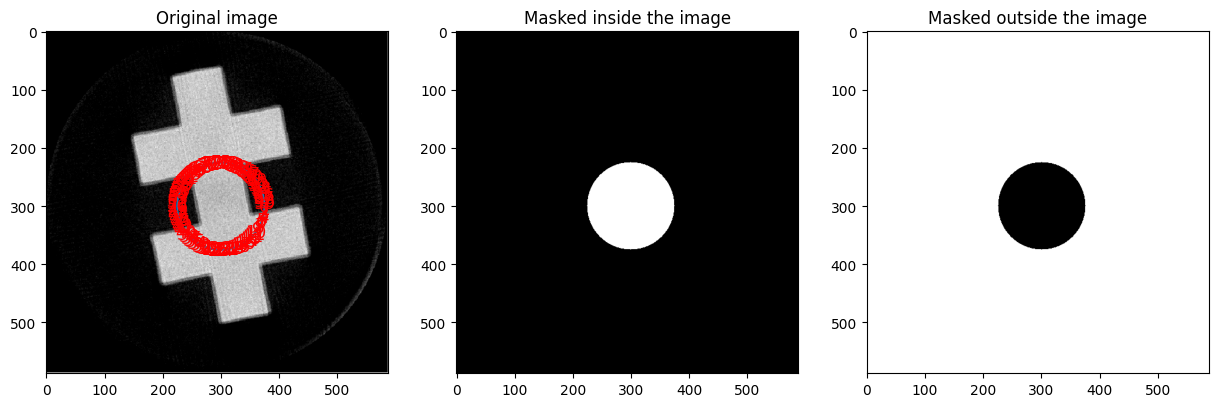

In [7]:
center = (300,300)
radius = 75
numbers = 100
circle_points = initialize_circle(center, radius, numbers)          # create the points for the circles

m_in, m_out = get_means(image, circle_points)
circle_mask = polygon2mask(image.shape, circle_points)
print('The mean inside the snake is given as\n', m_in)
print('The mean outside the snake is given as\n', m_out)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image with numbers instead of markers
ax[0].set_title('Original image')
ax[0].plot(circle_points[:,0], circle_points[:,1])
ax[0].imshow(image, cmap='gray')
for i, (x, y) in enumerate(circle_points): 
    ax[0].text(x, y, str(i), fontsize=12, ha='center', va='center', color='red')

# Plot the masked inside the image
ax[1].set_title('Masked inside the image')
ax[1].imshow(circle_mask, cmap='gray')

# Plot the masked outside the image
ax[2].set_title('Masked outside the image')
ax[2].imshow(circle_mask == 0, cmap='gray')

plt.show()


## task 5

In [8]:
#def calculate_I(image, snake_points):
#    x = np.arange(image.shape[1]) 
#    y = np.arange(image.shape[0]) 
#
#    interp = RegularGridInterpolator(points=(x, y), values=image)
#
#    return interp((snake_points[:,0], snake_points[:,1]))[:, None]
#
#image_intensity = calculate_I(image, circle_points)

def calculate_I(image, snake_points, neighborhood_size=1):
    """
    Calculate the image intensity values at the snake points by averaging the intensities
    of neighboring pixels.

    Parameters:
        image (np.ndarray): The input image as a 2D array.
        snake_points (np.ndarray): The points on the snake as a 2D array of shape (n, 2).
        neighborhood_size (int): The size of the neighborhood around each point (default is 1).

    Returns:
        np.ndarray: The averaged image intensity values at the snake points.
    """
    intensities = []

    for point in snake_points:
        x, y = point
        x, y = int(round(x)), int(round(y))  # Ensure coordinates are integers

        # Define the neighborhood boundaries
        x_start = max(0, x - neighborhood_size)
        x_end = min(image.shape[1], x + neighborhood_size + 1)
        y_start = max(0, y - neighborhood_size)
        y_end = min(image.shape[0], y + neighborhood_size + 1)

        # Extract the neighborhood
        neighborhood = image[y_start:y_end, x_start:x_end]

        # Calculate the average intensity in the neighborhood
        average_intensity = np.mean(neighborhood)
        intensities.append(average_intensity)

    return np.array(intensities)[:, None]

image_intensity = calculate_I(image, circle_points)
# print("Image Intensity:\n", image_intensity)

## task 6

In [9]:
def calculate_N(snake_points):
    """
    Calculate the normal vectors for a set of snake points.

    This function computes the normal vectors for each point in a sequence of snake points.
    The normals are calculated as vectors orthogonal to the tangent vectors at each point.

    Parameters:
        snake_points (np.ndarray): A 2D NumPy array where each row represents a point in the snake.
                                  The array should have the shape (n, 2), where n is the number of points.

    Returns:
        np.ndarray: A 2D NumPy array of shape (n, 2) containing the normalized normal vectors
                    for each point in the snake.

    The normals are computed by averaging the tangent vectors before and after each point,
    then calculating the orthogonal vector. The resulting normal vectors are normalized
    to have unit length.
    """

    ci = snake_points
    ci_1 = np.vstack([ci[-1, :], ci[:-1, :]])  # Previous points
    ci1 = np.vstack([ci[1:, :], ci[0, :]])    # Next points

    # Calculate tangent vectors
    tangent_before = ci_1 - ci 
    tangent_after = ci - ci1

    # Average the tangent vectors
    avg_tangent = (tangent_before + tangent_after) / 2

    # Calculate the normal vectors (orthogonal to the tangent)
    # Can be obtained using (-ty, tx)
    normals = np.empty_like(avg_tangent)
    normals[:, 0] = -avg_tangent[:, 1]
    normals[:, 1] = avg_tangent[:, 0]

    # Normalize the normal vectors
    normals /= np.linalg.norm(normals, axis=1)[:, None]

    return normals

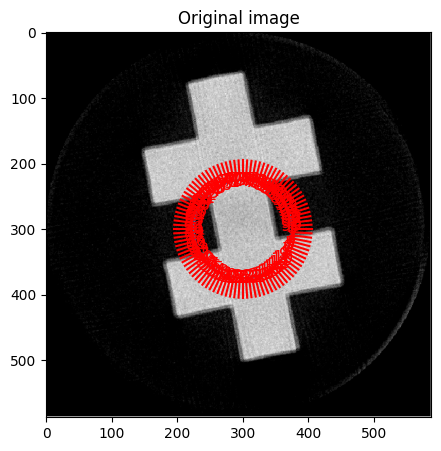

In [10]:
N = calculate_N(circle_points)

plt.figure(figsize=(5,5))
plt.title('Original image')
plt.plot(circle_points[:,0], circle_points[:,1])
plt.imshow(image, cmap='gray')
for i, (x, y) in enumerate(circle_points): 
    plt.text(x, y, str(i), fontsize=12, ha='center', va='center', color='red')
    x_new, y_new = (x,y) + N[i,:]*30
    plt.plot([x,x_new], [y, y_new], 'r-')

## task 7

In [11]:
alpha = 0.1
beta = 0.1
B_int = smoothing_matrix(alpha, beta, circle_points.shape[0])

## task 8

In [12]:
dis_points = distribute_points(circle_points)
remove_inter_points = remove_intersections(circle_points)
# print('The distributed points are given as\n', dis_points)
# print('The removed intersection points are given as\n', remove_inter_points)

## task 9

In [13]:
def calculate_Fext(image, snake_points):
    m_in, m_out = get_means(image, snake_points)
    I = calculate_I(image, snake_points)    
    return (m_in - m_out)*(2*I - m_in - m_out)    

f_ext = calculate_Fext(image, circle_points)

In [14]:
def update_snake_points(snake_points_old, image, tau, B_init):
    N_old = calculate_N(snake_points_old)
    f_ext = calculate_Fext(image, snake_points_old)
    snake_points_new =  B_init @ (snake_points_old + tau * f_ext * N_old)
    snake_points_new = distribute_points(snake_points_new)
    snake_points_new = remove_intersections(snake_points_new)
    return snake_points_new

tau = 0.1
c_new = update_snake_points(circle_points, image, tau, B_int)

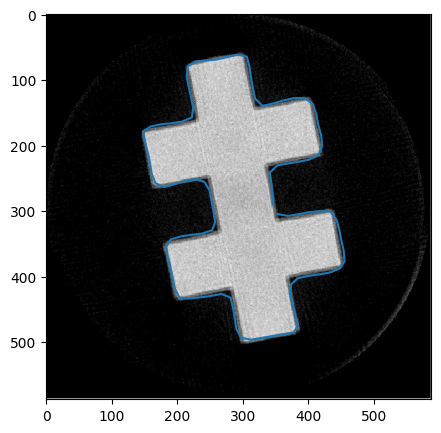

In [15]:
tau = 50

fig, ax = plt.subplots(figsize=(5,5))
ax.set_title('Original image')

for i in range(20):
    ax.clear()
    c_new = update_snake_points(circle_points, image, tau, B_int)
    ax.plot(c_new[:,0], c_new[:,1])
    circle_points = c_new
    ax.imshow(image, cmap='gray')
    display(fig)
    clear_output(wait=True)  
    
plt.show()

## task 10

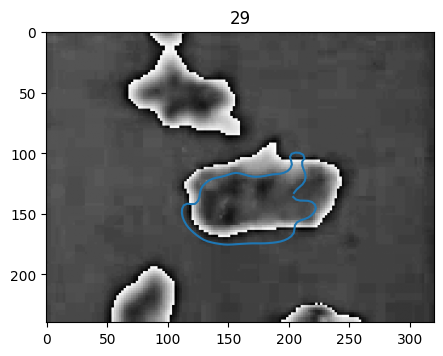

In [16]:
alpha = 0.1
beta = 0.1
tau = 0.03
center = (180, 130)
radius = 40
number_points = 100
snake_points = initialize_circle(center, radius, number_points)
B_int = smoothing_matrix(alpha, beta, snake_points.shape[0])

fig, ax = plt.subplots(figsize=(5,5))
ax.set_title('Original image')

for j, image in enumerate(frames):
    for i in range(10):
        ax.clear() 
        snake_points_new = update_snake_points(snake_points, image, tau, B_int)
        ax.plot(snake_points_new[:,0], snake_points_new[:,1])
        snake_points = snake_points_new
        ax.imshow(image, cmap='gray')
        ax.set_title(j)
        display(fig)
        clear_output(wait=True)  
        
        
    plt.show()


## QUIZ



### 1) 

Consider modifying Equation (6.3) from the lecture notes by removing internal forces and making all scalar components of external forces equal to 1, such that you are left with

$$C_t=C_t−1+N^{t−1}$$

Assume you initialize a circular snake with a radius of 100 pixels and iterativelyevolve the snake 10 times. What is the area ofΩin(you don’t need to initializethe snake, just calculate the area

In [17]:
radius = 100
area = np.pi*radius**2
print('The area is:', area)

The area is: 31415.926535897932


### 2)

Consider the image ```plusplus.png``` with data type transformed to double precision by dividing all pixel intensities with 255. Initialize a circular snake with a radius of 120 pixels in the centre of the image. Consider now a snake point,positioned where image intensity is 0.8.  What is the value off ext affecting this point?

(588, 588)
The min and max for the image is 0.0 1.0
The image type is: float64
The inner mean is 0.5686775796193259
The outer mean is: 0.10574267673708086
The external force is f_ext: 0.4284831687334201


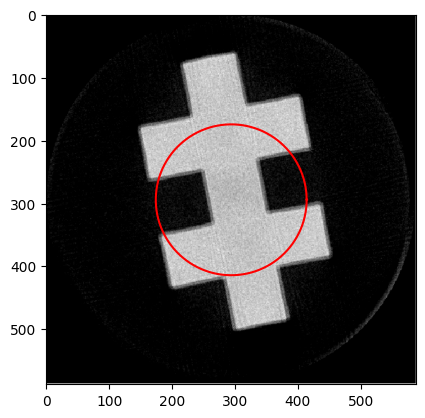

In [18]:
image = get_gray_image_float(PATH + 'plusplus.png').astype('double')
print(image.shape)

print('The min and max for the image is', np.min(image), np.max(image))
print('The image type is:', image.dtype)

# The center of the image
x, y = (image.shape[0]/2, image.shape[1]/2)
radius = 120
circle_points = initialize_circle((x,y), radius, numbers=1000)
m_in, m_out = get_means(image, circle_points)

print('The inner mean is', m_in)
print('The outer mean is:', m_out)
I = 0.8
f_ext = (m_in - m_out)*(2*I - m_in - m_out)    
print('The external force is f_ext:', f_ext)

plt.imshow(image, cmap='gray')
plt.plot(circle_points[:,0], circle_points[:,1], '-r')

### 3) 
 For the same image and the same curve, what is the value of $E_ext$ according to the first equation in the Section 6.1 of the course note

In [19]:
E_ext = np.sum((image[circle_mask] - m_in)**2) + np.sum((image[circle_mask==0] - m_out)**2) 
print('The external energy is:', E_ext)

The external energy is: 28763.793867469445
